In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from get_pokemon_stats import get_pokemon_stats
%matplotlib inline

## 1. 데이터 로딩 / データの取得

- There are many ways to acquire data, but used the API provided by the RapidAPI site.
- If you sign up, API KEY will be issued.

In [2]:
# https://rapidapi.com/brianiswu/api/pokemon-go1/
API_KEY = "YOUR_API_KEY"

- Acquire the information for each Pokémon.

In [3]:
df = get_pokemon_stats(API_KEY)
df.head()

,pokemon_id,pokemon_name,form,base_attack,base_defense,base_stamina,max_cp,candy_required,type1,type2
0,1,Bulbasaur,Normal,118,111,128,1115,25,Grass,Poison
1,1,Bulbasaur,Purified,118,111,128,1115,22,Grass,Poison
2,1,Bulbasaur,Shadow,118,111,128,1115,25,Grass,Poison
3,2,Ivysaur,Normal,151,143,155,1699,100,Grass,Poison
4,2,Ivysaur,Purified,151,143,155,1699,90,Grass,Poison


## 2. 데이터 전처리 / データの前処理

### Rename Pokémon to Japanese

- Mapping information for English and Japanese is stored in the "pokemon_name_master.csv" file.

In [4]:
df_names = pd.read_csv("pokemon_name_master.csv")
df = pd.merge(df, df_names, on="pokemon_name", how="left")
df.head()

,pokemon_id,pokemon_name,form,base_attack,base_defense,base_stamina,max_cp,candy_required,type1,type2,japanese_name
0,1,Bulbasaur,Normal,118,111,128,1115,25,Grass,Poison,フシギダネ
1,1,Bulbasaur,Purified,118,111,128,1115,22,Grass,Poison,フシギダネ
2,1,Bulbasaur,Shadow,118,111,128,1115,25,Grass,Poison,フシギダネ
3,2,Ivysaur,Normal,151,143,155,1699,100,Grass,Poison,フシギソウ
4,2,Ivysaur,Purified,151,143,155,1699,90,Grass,Poison,フシギソウ


### Limit to the normal form, leaving only the columns to be used.

In [5]:
df = df.loc[(df["form"] == "Normal") | (df["form"].isnull()), :]
df = df[["japanese_name", "base_attack", "base_defense", "base_stamina", "max_cp", "type1", "type2"]]
df = df.reset_index(drop=True)
df.head()

,japanese_name,base_attack,base_defense,base_stamina,max_cp,type1,type2
0,フシギダネ,118,111,128,1115,Grass,Poison
1,フシギソウ,151,143,155,1699,Grass,Poison
2,ヒトカゲ,116,93,118,980,Fire,None
3,リザード,158,126,151,1653,Fire,None
4,ゼニガメ,94,121,127,946,Water,None


## 3. 스탯을 활용한 계층적 클러스터링 / ステータスを使って階層型クラスタリング

### Feature scaling

In [6]:
scaler = StandardScaler()
data_stats = df.loc[:, "base_attack":"max_cp"].values
data_stats = scaler.fit_transform(data_stats)

### Clustering

In [7]:
linkage_result = linkage(data_stats, method="ward")

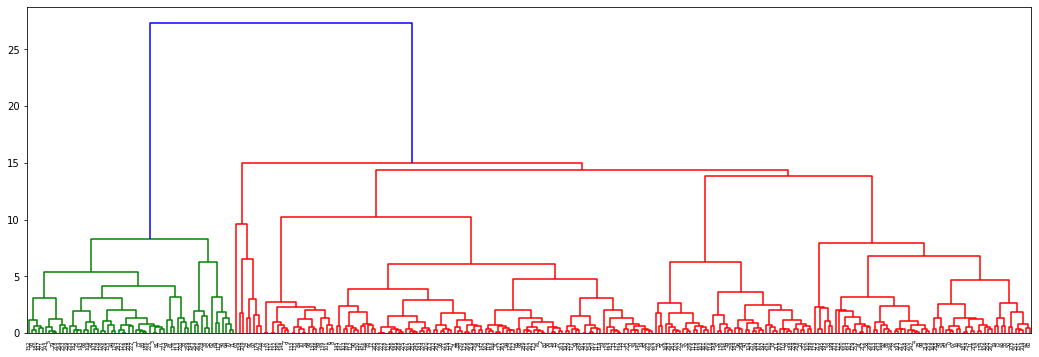

In [8]:
plt.figure(figsize=(18, 6))
dendrogram(linkage_result)
plt.show()

### Split into 5 clusters

In [9]:
clusters = fcluster(linkage_result, 5, criterion="maxclust")

- Evolved Pokémon were classified into different clusters because of the difference in the status.

In [10]:
df_result = df.copy()
df_result["cluster"] = clusters
df_result.head()

,japanese_name,base_attack,base_defense,base_stamina,max_cp,type1,type2,cluster
0,フシギダネ,118,111,128,1115,Grass,Poison,5
1,フシギソウ,151,143,155,1699,Grass,Poison,1
2,ヒトカゲ,116,93,118,980,Fire,None,3
3,リザード,158,126,151,1653,Fire,None,1
4,ゼニガメ,94,121,127,946,Water,None,5


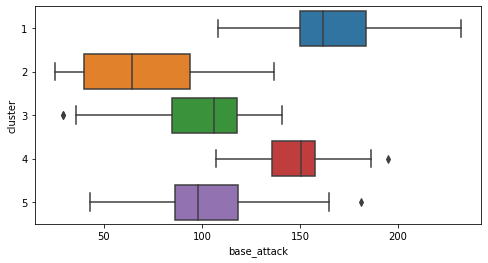

In [11]:
plt.figure(figsize=(8, 4))
sns.boxplot(y="cluster", x="base_attack", data=df_result, orient="h")

- Cluster 5 is defense-centric

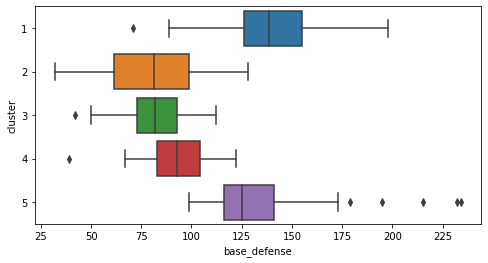

In [12]:
plt.figure(figsize=(8, 4))
sns.boxplot(y="cluster", x="base_defense", data=df_result, orient="h")

In [13]:
df_result[df_result["cluster"] == 5].sort_values("base_defense", ascending=False).head()

,japanese_name,base_attack,base_defense,base_stamina,max_cp,type1,type2,cluster
173,サマヨール,124,234,120,1591,Ghost,None,5
53,イワーク,85,232,111,1101,Rock,Ground,5
149,ノズパス,82,215,102,993,Rock,None,5
195,タテトプス,76,195,102,890,Rock,Steel,5
215,タマンタ,105,179,128,1248,Water,Flying,5


- Cluster 2 is stamina-centric

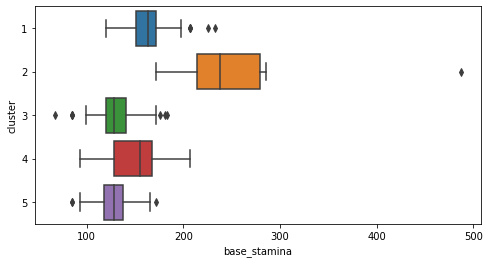

In [14]:
plt.figure(figsize=(8, 4))
sns.boxplot(y="cluster", x="base_stamina", data=df_result, orient="h")

In [15]:
df_result[df_result["cluster"] == 2].sort_values("base_stamina", ascending=False).head()

,japanese_name,base_attack,base_defense,base_stamina,max_cp,type1,type2,cluster
63,ラッキー,60,128,487,1255,Normal,None,2
209,ゴンベ,137,117,286,1892,Normal,None,2
158,ホエルコ,136,68,277,1468,Water,None,2
23,プリン,80,41,251,724,Normal,Fairy,2
206,ピンプク,25,77,225,371,Normal,None,2


## 4. 포켓몬의 타입 정보를 추가 / タイプ情報を加える

- Each Pokémon has a maximum of two types.
- The types owned by Pokémon are replaced by 1 and the other types are replaced by 0.

In [6]:
POKEMON_TYPES = ["Normal", "Fire", "Water", "Electric", "Grass", "Ice",
                 "Fighting", "Poison", "Ground", "Flying", "Psychic", "Bug",
                 "Rock", "Ghost", "Dragon", "Dark", "Steel", "Fairy"]

In [7]:
df_types = df.loc[:, ["japanese_name", "type1", "type2"]]
for p_type in POKEMON_TYPES:
    df_types.loc[:, p_type] = df_types.apply(lambda x: 1 if (x[1] == p_type) or (x[2] == p_type) else 0, axis=1).values
df_types.head()

,japanese_name,type1,type2,Normal,Fire,Water,Electric,Grass,Ice,Fighting,...,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
0,フシギダネ,Grass,Poison,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,フシギソウ,Grass,Poison,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ヒトカゲ,Fire,None,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,リザード,Fire,None,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ゼニガメ,Water,None,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Combine the features

- Apply the MinMaxScaler this time (because of a more understandable outcome)

In [8]:
scaler = MinMaxScaler()
data_stats = df.loc[:, "base_attack":"max_cp"].values
data_stats = scaler.fit_transform(data_stats)

In [9]:
data_types = df_types.loc[:, "Normal":"Fairy"].values
data = np.concatenate([data_stats, data_types], axis=1)

## 5. 타입 정보를 가미하여 계층적 클리스터링 / タイプ情報を加えて階層型クラスタリング

In [10]:
linkage_result = linkage(data, method="ward")

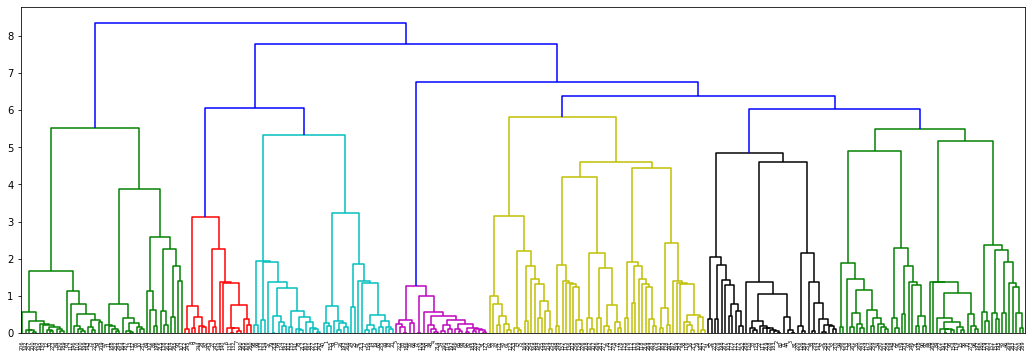

In [11]:
plt.figure(figsize=(18, 6))
dendrogram(linkage_result)
plt.show()

### Split into 7 clusters

In [12]:
clusters = fcluster(linkage_result, 7, criterion="maxclust")

In [13]:
df_result = df.copy()
df_result["cluster"] = clusters
df_result.head()

,japanese_name,base_attack,base_defense,base_stamina,max_cp,type1,type2,cluster
0,フシギダネ,118,111,128,1115,Grass,Poison,3
1,フシギソウ,151,143,155,1699,Grass,Poison,3
2,ヒトカゲ,116,93,118,980,Fire,None,6
3,リザード,158,126,151,1653,Fire,None,6
4,ゼニガメ,94,121,127,946,Water,None,4


- Count the number of types by cluster

In [14]:
df_result_types = pd.DataFrame(columns=POKEMON_TYPES)
for i in range(1, 8):
    for p_type in POKEMON_TYPES:
        df_result_types.loc["cluster{}".format(i), p_type] = len(df_result.loc[(df_result["cluster"] == i) & ((df_result["type1"] == p_type) | (df_result["type2"] == p_type))])
df_result_types = df_result_types.astype("int")
df_result_types

,Normal,Fire,Water,Electric,Grass,Ice,Fighting,Poison,Ground,Flying,Psychic,Bug,Rock,Ghost,Dragon,Dark,Steel,Fairy
cluster1,36,0,3,0,0,0,0,0,1,23,0,4,0,0,0,2,0,1
cluster2,0,0,1,0,3,0,0,7,1,0,0,20,0,0,0,0,0,0
cluster3,0,0,3,0,28,0,1,21,0,4,1,0,0,0,0,0,0,0
cluster4,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cluster5,0,2,10,0,3,10,0,1,28,1,2,2,19,1,11,12,0,0
cluster6,0,20,1,0,0,0,12,2,0,1,0,1,0,11,0,1,0,0
cluster7,3,0,2,17,2,0,1,0,0,2,20,1,3,0,0,1,13,11


## 6. 결과에 대한 고찰 / 結果の考察

In [20]:
def count_sub_types(df, main_type):
    result = pd.DataFrame()
    result["sub_type"] = df.loc[(df["type1"] == main_type) | (df["type2"] == main_type), ["type1", "type2"]].apply(lambda x: x[1] if x[0] == main_type else x[0], axis=1)
    return result["sub_type"].value_counts(dropna=False)

### cluster1

- Mainly normal-type and flying-type
- Due to the presence of Pokémon with both normal and flying types, it is thought that they are tied to the same cluster.

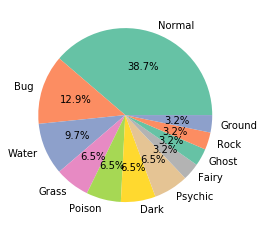

In [21]:
sub_type_counts = count_sub_types(df_result, "Flying")

sns.set_palette("Set2")
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct="%1.1f%%")
plt.show()

## cluster2 & cluster3

- Cluster 2 and Cluster 3 are relatively close to each other because there are many patterns of poison + grass or poison + bug.

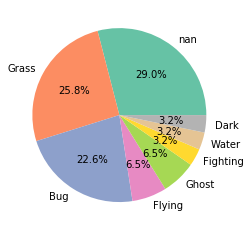

In [24]:
sub_type_counts = count_sub_types(df_result, "Poison")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct="%1.1f%%")
plt.show()

## cluster4

- Many water-type Pokémon do not have an additional type.

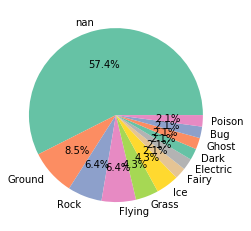

In [25]:
sub_type_counts = count_sub_types(df_result, "Water")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct="%1.1f%%")
plt.show()

## cluster5

- Ground and rock types are highly friendly.

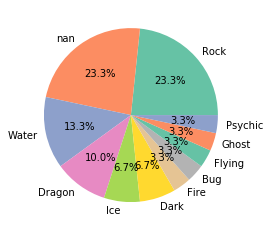

In [26]:
sub_type_counts = count_sub_types(df_result, "Ground")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct="%1.1f%%")
plt.show()

- Dragon-type has only ground-type or dark-type as an additional type.

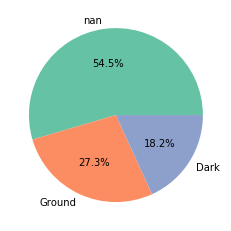

In [27]:
sub_type_counts = count_sub_types(df_result, "Dragon")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct="%1.1f%%")
plt.show()

## cluster6

- Many fire-type and fighting-type Pokémon do not have an additional type.
- However, it is relatively common to have both.

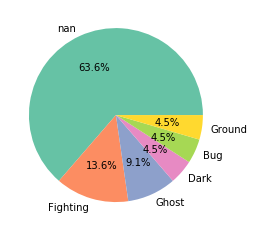

In [31]:
sub_type_counts = count_sub_types(df_result, "Fire")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct="%1.1f%%")
plt.show()

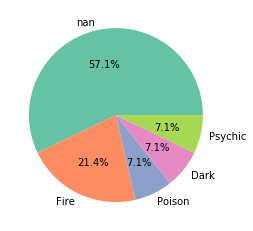

In [32]:
sub_type_counts = count_sub_types(df_result, "Fighting")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct="%1.1f%%")
plt.show()

## cluster7

- Steel-type is highly friendly with psychic-type or electric-type.

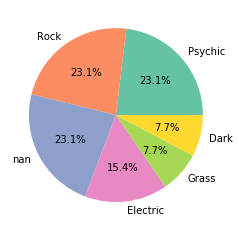

In [35]:
sub_type_counts = count_sub_types(df_result, "Steel")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct="%1.1f%%")
plt.show()

- Electric-type tends strongly not to have different types.
- However, some have steel-type.

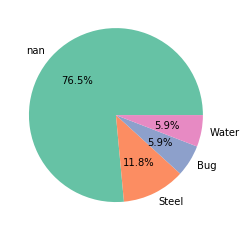

In [36]:
sub_type_counts = count_sub_types(df_result, "Electric")

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(sub_type_counts.values, labels=sub_type_counts.index, autopct="%1.1f%%")
plt.show()